In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

# Building Models in PyMC

Bayesian inference begins with specification of a probability model
relating unknown variables to data. PyMC provides three basic building
blocks for Bayesian probability models: `Stochastic`, `Deterministic`
and `Potential`.

A `Stochastic` object represents a variable whose value is not
completely determined by its parents, and a `Deterministic` object
represents a variable that is entirely determined by its parents. In
object-oriented programming parlance, `Stochastic` and `Deterministic`
are subclasses of the `Variable` class, which only serves as a template
for other classes and is never actually implemented in models.

The third basic class, `Potential`, represents 'factor potentials', which are *not* variables but simply
log-likelihood terms and/or constraints that are multiplied into joint
distributions to modify them. `Potential` and `Variable` are subclasses
of `Node`.

## The Stochastic class

A stochastic variable has the following primary attributes:

`value`
:   The variable's current value.

`logp`
:   The log-probability of the variable's current value given the values
    of its parents.

A stochastic variable can optionally be endowed with a method called
`random`, which draws a value for the variable given the values of its
parents. 

### Creation of stochastic variables

There are three main ways to create stochastic variables, called the
**automatic**, **decorator**, and **direct** interfaces.

**Automatic**

Stochastic variables with standard distributions provided by PyMC can be created in a
single line using special subclasses of `Stochastic`. For example, the uniformly-distributed discrete variable $switchpoint$ in the coal mining disasters model is created using the automatic interface as follows:

In [2]:
import pymc as pm
import numpy as np
from pymc.examples import disaster_model

switchpoint = pm.DiscreteUniform('switchpoint', lower=0, upper=110)

Similarly, the rate parameters can automatically be given exponential priors:

In [3]:
early_mean = pm.Exponential('early_mean', beta=1., value=1)
late_mean = pm.Exponential('late_mean', beta=1., value=1)

**Decorator**

Uniformly-distributed discrete stochastic variable $switchpoint$ in the disasters model could alternatively be created from a function that computes its log-probability as follows:

In [4]:
@pm.stochastic
def switchpoint(value=1900, t_l=1851, t_h=1962):
    """The switchpoint for the rate of disaster occurrence."""
    if value > t_h or value < t_l:
        # Invalid values
        return -np.inf
    else:
        # Uniform log-likelihood
        return -np.log(t_h - t_l + 1)

Note that this is a simple Python function preceded by a Python
expression called a **decorator**, here called
`@stochastic`. Generally, decorators enhance functions with
additional properties or functionality. The `Stochastic` object
produced by the `@stochastic` decorator will evaluate its
log-probability using the function `switchpoint`. The `value`
argument, which is required, provides an initial value for the
variable. The remaining arguments will be assigned as parents of
`switchpoint` (*i.e.* they will populate the `parents` dictionary).

To emphasize, the Python function decorated by `@stochastic` should
compute the *log*-density or *log*-probability of the variable. That
is why the return value in the example above is $-\log(t_h-t_l+1)$
rather than $1/(t_h-t_l+1)$.

**Direct**

Its also possible to instantiate `Stochastic` directly:

In [5]:
def switchpoint_logp(value, t_l, t_h):
    if value > t_h or value < t_l:
        return -np.inf
    else:
        return -np.log(t_h - t_l + 1)

def switchpoint_rand(t_l, t_h):
    return np.round( (t_l - t_h) * np.random.random() ) + t_l

switchpoint = pm.Stochastic( logp = switchpoint_logp,
                doc = 'The switchpoint for the rate of disaster occurrence.',
                name = 'switchpoint',
                parents = {'t_l': 1851, 't_h': 1962},
                random = switchpoint_rand,
                trace = True,
                value = 1900,
                dtype=int,
                rseed = 1.,
                observed = False,
                cache_depth = 2,
                plot=True,
                verbose = 0)

Notice that the log-probability and random variate functions are
specified externally and passed to `Stochastic` as arguments. This
is a rather awkward way to instantiate a stochastic variable;
consequently, such implementations should be rare.

## Data Stochastics

Data are represented by `Stochastic` objects whose `observed` attribute
is set to `True`. If a stochastic variable's `observed` flag is `True`,
its value cannot be changed, and it won't be sampled by the fitting
method.

In each interface, an optional keyword argument `observed` can be set to
`True`. In the decorator interface, the
`@observed` decorator is used instead of `@stochastic`:

In [6]:
from scipy.stats.distributions import poisson

@pm.observed
def likelihood(value=[1, 2, 1, 5], parameter=3):
    return poisson.logpmf(value, parameter).sum()

In the other interfaces, the `observed=True` argument is added to the
instantiation of the `Stochastic`, or its subclass:

In [7]:
disasters = pm.Poisson('disasters', mu=2, 
                       value=disaster_model.disasters_array, 
                       observed=True)

## The Deterministic class

The `Deterministic` class represents variables whose values are
completely determined by the values of their parents. For example, in
our disasters model, $rate$ is a `deterministic` variable.

In [8]:
@pm.deterministic
def rate(s=switchpoint, e=early_mean, l=late_mean):
    ''' Concatenate Poisson means '''
    out = np.empty(len(disaster_model.disasters_array))
    out[:s] = e
    out[s:] = l
    return out

so `rate`'s value can be computed exactly from the values of its parents
`early_mean`, `late_mean` and `switchpoint`.

A `Deterministic` variable's most important attribute is `value`, which
gives the current value of the variable given the values of its parents.
Like `Stochastic`'s `logp` attribute, this attribute is computed
on-demand and cached for efficiency.

A Deterministic variable has the following additional attributes:

`parents`
:   A dictionary containing the variable's parents. The keys of the dictionary correspond to the names assigned to the variable's parents by the variable, and the values correspond to the actual parents.

`children`
:   A set containing the variable's children, which must be nodes.

Deterministic variables have no methods.

### Creation of deterministic variables

Deterministic variables are less complicated than stochastic variables,
and have similar **automatic**, **decorator**, and **direct**
interfaces:

**Automatic**

A handful of common functions have been wrapped in Deterministic
objects. These are brief enough to list:

`LinearCombination`
:   Has two parents $x$ and $y$, both of which must be iterable (*i.e.* vector-valued). This function returns:

\\[\sum_i x_i^T y_i\\]

`Index`
:   Has two parents $x$ and `index`. $x$ must be iterable, `index` must be valued as an integer. 

\\[x[\text{index}]\\]


`Index` is useful for implementing dynamic models, in which the parent-child connections change.

`Lambda`
:   Converts an anonymous function (in Python, called **lambda functions**) to a `Deterministic` instance on a single line.

`CompletedDirichlet`
:   PyMC represents Dirichlet variables of length $k$ by the first $k-1$ elements; since they must sum to 1, the $k^{th}$ element is determined by the others. `CompletedDirichlet` appends the $k^{th}$ element to the value of its parent $D$.

`Logit`, `InvLogit`, `StukelLogit`, `StukelInvLogit`
:   Common link functions for generalized linear models, and their inverses.

Its a good idea to use these classes when feasible in order to give hints to step methods.

Certain elementary operations on variables create deterministic variables. For example:

In [9]:
x = pm.MvNormal('x', np.ones(3), np.eye(3))
y = pm.MvNormal('y', np.ones(3), np.eye(3))
x+y

<pymc.PyMCObjects.Deterministic '(x_add_y)' at 0x10a59de48>

In [10]:
print(x[0])

x[0]


In [11]:
print(x[0]+y[2])

(x[0]_add_y[2])


All the objects thus created have `trace=False` and `plot=False` by default.

**Decorator**

We have seen in the disasters example how the decorator interface is used to create a deterministic variable. Notice that rather than returning the log-probability, as is the
case for `Stochastic` objects, the function returns the value of the deterministic object, given its parents. Also notice that, unlike for `Stochastic` objects, there is no `value` argument
passed, since the value is calculated deterministically by the
function itself. 


**Direct**

`Deterministic` objects can also be instantiated directly:

In [12]:
def rate_eval(switchpoint=switchpoint, early_mean=early_mean, late_mean=late_mean):
    value = np.zeros(111)
    value[:switchpoint] = early_mean
    value[switchpoint:] = late_mean
    return value

rate = pm.Deterministic(eval = rate_eval,
                  name = 'rate',
                  parents = {'switchpoint': switchpoint, 
                          'early_mean': early_mean, 
                          'late_mean': late_mean},
                  doc = 'The rate of disaster occurrence.',
                  trace = True,
                  verbose = 0,
                  dtype=float,
                  plot=False,
                  cache_depth = 2)

## Containers

In some situations it would be inconvenient to assign a unique label to
each parent of some variable. Consider $y$ in the following model:

$$\begin{align*}
x_0 &\sim N (0,\tau_x)\\
x_{i+1}|x_i &\sim \text{N}(x_i, \tau_x)\\
&i=0,\ldots, N-2\\
y|x &\sim N \left(\sum_{i=0}^{N-1}x_i^2,\tau_y\right)
\end{align*}$$

Here, $y$ depends on every element of the Markov chain $x$, but we
wouldn't want to manually enter $N$ parent labels `x_0`,
`x_1`, etc.

This situation can be handled naturally in PyMC:

In [13]:
N = 10
x_0 = pm.Normal('x_0', mu=0, tau=1)

x = np.empty(N, dtype=object)
x[0] = x_0

for i in range(1, N):

    x[i] = pm.Normal('x_%i' % i, mu=x[i-1], tau=1)

@pm.observed
def y(value=1, mu=x, tau=100):
    return pm.normal_like(value, (mu**2).sum(), tau)

PyMC automatically wraps array $x$ in an appropriate `Container` class.
The expression `'x_%i' % i` labels each `Normal` object in the container
with the appropriate index $i$. For example, if `i=1`, the name of the
corresponding element becomes `x_1`.

Containers, like variables, have an attribute called `value`. This
attribute returns a copy of the (possibly nested) iterable that was
passed into the container function, but with each variable inside
replaced with its corresponding value.

## The Potential class

For some applications, we want to be able to modify the joint density by
incorporating terms that don't correspond to probabilities of variables
conditional on parents, for example:

$$\begin{eqnarray*}
p(x_0, x_2, \ldots x_{N-1}) \propto \prod_{i=0}^{N-2} \psi_i(x_i, x_{i+1}).
\end{eqnarray*}$$

In other cases we may want to add probability terms to existing models.
For example, suppose we want to constrain the difference between the early and late means in the disaster model to be less than 1, so that the joint density becomes:

$$p(y,\tau,\lambda_1,\lambda_2) \propto p(y|\tau,\lambda_1,\lambda_2) p(\tau) p(\lambda_1) p(\lambda_2) I(|\lambda_2-\lambda_1| \lt 1)$$

Arbitrary factors are implemented by objects of class `Potential`. Bayesian
hierarchical notation doesn't accomodate these potentials. 

Potentials have one important attribute, `logp`, the log of their
current probability or probability density value given the values of
their parents. The only other additional attribute of interest is
`parents`, a dictionary containing the potential's parents. Potentials
have no methods. They have no `trace` attribute, because they are not
variables. They cannot serve as parents of variables (for the same
reason), so they have no `children` attribute.

### Creation of Potentials

There are two ways to create potentials:

**Decorator**

A potential can be created via a decorator in a way very similar to
`Deterministic`'s decorator interface:

In [14]:
@pm.potential
def rate_constraint(l1=early_mean, l2=late_mean):
    if np.abs(l2 - l1) > 1:
        return -np.inf
    return 0

The function supplied should return the potential's current
*log*-probability or *log*-density as a Numpy `float`. The
`potential` decorator can take `verbose` and `cache_depth` arguments
like the `stochastic` decorator.

**Direct**

The same potential could be created directly as follows:


In [15]:
def rate_constraint_logp(l1=early_mean, l2=late_mean):
    if np.abs(l2 - l1) > 1:
        return -np.inf
    return 0

rate_constraint = pm.Potential(logp = rate_constraint_logp,
                    name = 'rate_constraint',
                    parents = {'l1': early_mean, 'l2': late_mean},
                    doc = 'Constraint on rate differences',
                    verbose = 0,
                    cache_depth = 2)

## Example: Bioassay model

Recall from a previous lecture the bioassay example, where the number of deaths in a toxicity experiment was modeled as a binomial response, with the probability of death being a linear function of dose:

$$\begin{aligned}
y_i &\sim \text{Bin}(n_i, p_i) \\
\text{logit}(p_i) &= a + b x_i
\end{aligned}$$

Implement this model in PyMC (we will show you how to fit the model later!)

In [16]:
# Log dose in each group
log_dose = [-.86, -.3, -.05, .73]

# Sample size in each group
n = 5

# Outcomes
deaths = [0, 1, 3, 5]

In [17]:
## Write your answer here

## Fitting Models

PyMC provides three objects that fit models:

- `MCMC`, which coordinates Markov chain Monte Carlo algorithms. The actual work of updating stochastic variables conditional on the rest of the model is done by `StepMethod` objects.

- `MAP`, which computes maximum *a posteriori* estimates.

- `NormApprox`, the joint distribution of all stochastic variables in a model is approximated as normal using local information at the maximum *a posteriori* estimate.

All three objects are subclasses of `Model`, which is PyMC's base class
for fitting methods. `MCMC` and `NormApprox`, both of which can produce
samples from the posterior, are subclasses of `Sampler`, which is PyMC's
base class for Monte Carlo fitting methods. `Sampler` provides a generic
sampling loop method and database support for storing large sets of
joint samples. These base classes implement some basic methods that are
inherited by the three implemented fitting methods, so they are
documented at the end of this section.

### Maximum a posteriori estimates

The `MAP` class sets all stochastic variables to their maximum *a
posteriori* values using functions in SciPy's `optimize` package; hence,
SciPy must be installed to use it. `MAP` can only handle variables whose
dtype is `float`, so it will not work, for example, on the disaster model example. 

We can fit the bioassay example using `MAP`:

In [18]:
from pymc.examples import gelman_bioassay
M = pm.MAP(gelman_bioassay)
M.fit(method='fmin_powell')

This call will cause $M$ to fit the model using Powell's method, which does not require derivatives. The variables in `DisasterModel` have now been set to their maximum *a posteriori* values:

In [19]:
M.alpha.value

array(0.6514071740341959)

In [20]:
M.beta.value

array(6.491001139492115)

We can also calculate model selection statistics, AIC and BIC:

In [21]:
M.AIC

8.041670639609247

In [22]:
M.BIC

6.814259361849027

`MAP` has two useful methods:

`fit(method ='fmin', iterlim=1000, tol=.0001)`
:   The optimization method may be `fmin`, `fmin_l_bfgs_b`, `fmin_ncg`,
    `fmin_cg`, or `fmin_powell`. See the documentation of SciPy's
    `optimize` package for the details of these methods. The `tol` and
    `iterlim` parameters are passed to the optimization function under
    the appropriate names.

`revert_to_max()`
:   If the values of the constituent stochastic variables change after
    fitting, this function will reset them to their maximum *a
    posteriori* values.


The useful attributes of `MAP` are:

`logp`
:   The joint log-probability of the model.

`logp_at_max`
:   The maximum joint log-probability of the model.

`AIC`
:   Akaike's information criterion for this model.

`BIC`
:   The Bayesian information criterion for this model.

One use of the `MAP` class is finding reasonable initial states for MCMC
chains. Note that multiple `Model` subclasses can handle the same
collection of nodes.

### Normal approximations

The `NormApprox` class extends the `MAP` class by approximating the
posterior covariance of the model using the Fisher information matrix,
or the Hessian of the joint log probability at the maximum.

In [23]:
N = pm.NormApprox(gelman_bioassay)
N.fit()

The approximate joint posterior mean and covariance of the variables are
available via the attributes `mu` and `C`, which the the approximate posterior mean and variance/covariance, respectively:

In [24]:
N.mu[N.alpha]

array([ 0.6519219])

In [25]:
N.C[N.alpha, N.beta]

matrix([[  0.77914129,   2.00783688],
        [  2.00783688,  13.0306763 ]])

As with `MAP`, the variables have been set to their maximum *a
posteriori* values (which are also in the `mu` attribute) and the AIC
and BIC of the model are available.

We can also generate samples from the posterior:

In [26]:
N.sample(100)
N.trace('alpha')[:10]

array([-0.76583644,  2.1649439 , -0.59978319,  0.00488633,  1.94906764,
        0.72811949,  0.65837121,  0.14067333,  0.05917928,  0.51599836])

In addition to the methods and attributes of `MAP`, `NormApprox`
provides the following methods:

`sample(iter)`
:   Samples from the approximate posterior distribution are drawn and stored.

`isample(iter)`
:   An 'interactive' version of `sample()`: sampling can be paused, returning control to the user.

`draw`
:   Sets all variables to random values drawn from the approximate posterior.
    

### MCMC

The `MCMC` class implements PyMC's core business: producing Markov chain Monte Carlo samples for
a model's variables. Its primary job is to create and coordinate a collection of 'step
methods', each of which is responsible for updating one or more
variables. 

`MCMC` provides the following useful methods:

`sample(iter, burn, thin, tune_interval, tune_throughout, save_interval, ...)`
:   Runs the MCMC algorithm and produces the traces. The `iter` argument
controls the total number of MCMC iterations. No tallying will be
done during the first `burn` iterations; these samples will be
forgotten. After this burn-in period, tallying will be done each
`thin` iterations. Tuning will be done each `tune_interval`
iterations. If `tune_throughout=False`, no more tuning will be done
after the burnin period. The model state will be saved every
`save_interval` iterations, if given.

`isample(iter, burn, thin, tune_interval, tune_throughout, save_interval, ...)`
:   An interactive version of `sample`. The sampling loop may be paused
at any time, returning control to the user.

`use_step_method(method, *args, **kwargs)`:
:   Creates an instance of step method class `method` to handle some
stochastic variables. The extra arguments are passed to the `init`
method of `method`. Assigning a step method to a variable manually
will prevent the `MCMC` instance from automatically assigning one.
However, you may handle a variable with multiple step methods.

`stats()`:
:   Generate summary statistics for all nodes in the model.

The sampler's MCMC algorithms can be accessed via the `step_method_dict`
attribute. `M.step_method_dict[x]` returns a list of the step methods
`M` will use to handle the stochastic variable `x`.

After sampling, the information tallied by `M` can be queried via
`M.db.trace_names`. In addition to the values of variables, tuning
information for adaptive step methods is generally tallied. These
‘traces’ can be plotted to verify that tuning has in fact terminated. After sampling ends you can retrieve the trace as
`M.trace[’var_name’]`.

We can instantiate a MCMC sampler for the bioassay example as follows:

In [27]:
M = pm.MCMC(gelman_bioassay, db='sqlite')

## Step methods

Step method objects handle individual stochastic variables, or sometimes groups 
of them. They are responsible for making the variables they handle take single 
MCMC steps conditional on the rest of the model. Each subclass of 
``StepMethod`` implements a method called ``step()``, which is called by 
``MCMC``. Step methods with adaptive tuning parameters can optionally implement 
a method called ``tune()``, which causes them to assess performance (based on 
the acceptance rates of proposed values for the variable) so far and adjust.

The major subclasses of ``StepMethod`` are ``Metropolis`` and
``AdaptiveMetropolis``. PyMC provides several flavors of the 
basic Metropolis steps.

### Metropolis

``Metropolis`` and subclasses implement Metropolis-Hastings steps. To tell an 
``MCMC`` object :math:`M` to handle a variable :math:`x` with a Metropolis step 
method, you might do the following:

In [28]:
M.use_step_method(pm.Metropolis, M.alpha, proposal_sd=1., proposal_distribution='Normal')

`Metropolis` itself handles float-valued variables, and subclasses
`DiscreteMetropolis` and `BinaryMetropolis` handle integer- and
boolean-valued variables, respectively.

`Metropolis`' `__init__` method takes the following arguments:

`stochastic`
:   The variable to handle.

`proposal_sd`
:   A float or array of floats. This sets the proposal standard deviation if the proposal distribution is normal.

`scale`
:   A float, defaulting to 1. If the `scale` argument is provided but not `proposal_sd`, `proposal_sd` is computed as follows:

```python
if all(self.stochastic.value != 0.):
    self.proposal_sd = (ones(shape(self.stochastic.value)) * 
                   abs(self.stochastic.value) * scale)
else:
    self.proposal_sd = ones(shape(self.stochastic.value)) * scale
```

`proposal_distribution`
:   A string indicating which distribution should be used for proposals.
Current options are `'Normal'` and `'Prior'`. If
`proposal_distribution=None`, the proposal distribution is chosen
automatically. It is set to `'Prior'` if the variable has no
children and has a random method, and to `'Normal'` otherwise.

Alhough the `proposal_sd` attribute is fixed at creation, Metropolis
step methods adjust their initial proposal standard deviations using an
attribute called `adaptive_scale_factor`. During tuning, the
acceptance ratio of the step method is examined, and this scale factor
is updated accordingly. If the proposal distribution is normal,
proposals will have standard deviation
`self.proposal_sd * self.adaptive_scale_factor`.

By default, tuning will continue throughout the sampling loop, even
after the burnin period is over. This can be changed via the
`tune_throughout` argument to `MCMC.sample`. If an adaptive step
method's `tally` flag is set (the default for `Metropolis`), a trace of
its tuning parameters will be kept. If you allow tuning to continue
throughout the sampling loop, it is important to verify that the
'Diminishing Tuning' condition of [Roberts and Rosenthal (2007)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.jap/1183667414) is satisfied: the
amount of tuning should decrease to zero, or tuning should become very
infrequent.

If a Metropolis step method handles an array-valued variable, it
proposes all elements independently but simultaneously. That is, it
decides whether to accept or reject all elements together but it does
not attempt to take the posterior correlation between elements into
account. The `AdaptiveMetropolis` class (see below), on the other hand,
does make correlated proposals.

### AdaptiveMetropolis

The `AdaptativeMetropolis` (AM) step method works like a regular
Metropolis step method, with the exception that its variables are
block-updated using a multivariate jump distribution whose covariance is
tuned during sampling. Although the chain is non-Markovian, it has
correct ergodic properties ([Haario et al., 2001](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.bj/1080222083)).

`AdaptiveMetropolis` works on vector-valued, continuous stochastics:

In [29]:
from pymc.examples import disaster_model_linear
M = pm.MCMC(disaster_model_linear)
M.use_step_method(pm.AdaptiveMetropolis, M.params_of_mean)

`AdaptativeMetropolis`'s init method takes the following arguments:

`stochastics`
:   The stochastic variables to handle. These will be updated jointly.

`cov` (optional)
:   An initial covariance matrix. Defaults to the identity matrix,
adjusted according to the `scales` argument.

`delay` (optional)
:   The number of iterations to delay before computing the empirical
covariance matrix.

`scales` (optional):
:   The initial covariance matrix will be diagonal, and its diagonal
elements will be set to `scales` times the stochastics' values,
squared.

`interval` (optional):
:   The number of iterations between updates of the covariance matrix.
Defaults to 1000.

`greedy` (optional):
:   If `True`, only accepted jumps will be counted toward the delay
before the covariance is first computed. Defaults to `True`.

`shrink_if_necessary` (optional):
:   Whether the proposal covariance should be shrunk if the acceptance
rate becomes extremely small.

In this algorithm, jumps are proposed from a multivariate normal
distribution with covariance matrix $\Sigma$. The algorithm first
iterates until `delay` samples have been drawn (if `greedy` is true,
until `delay` jumps have been accepted). At this point, $\Sigma$ is
given the value of the empirical covariance of the trace so far and
sampling resumes. The covariance is then updated each `interval`
iterations throughout the entire sampling run. It is this constant
adaptation of the proposal distribution that makes the chain
non-Markovian.

### DiscreteMetropolis

This class is just like `Metropolis`, but specialized to handle
`Stochastic` instances with dtype `int`. The jump proposal distribution
can either be `'Normal'`, `'Prior'` or `'Poisson'` (the default). In the
normal case, the proposed value is drawn from a normal distribution
centered at the current value and then rounded to the nearest integer.

### BinaryMetropolis

This class is specialized to handle `Stochastic` instances with dtype
`bool`.

For array-valued variables, `BinaryMetropolis` can be set to propose
from the prior by passing in `dist="Prior"`. Otherwise, the argument
`p_jump` of the init method specifies how probable a change is. Like
`Metropolis`' attribute `proposal_sd`, `p_jump` is tuned throughout the
sampling loop via `adaptive_scale_factor`.

### Automatic assignment of step methods

Every step method subclass (including user-defined ones) that does not
require any `__init__` arguments other than the stochastic variable to
be handled adds itself to a list called `StepMethodRegistry` in the PyMC
namespace. If a stochastic variable in an `MCMC` object has not been
explicitly assigned a step method, each class in `StepMethodRegistry` is
allowed to examine the variable.

To do so, each step method implements a class method called
`competence(stochastic)`, whose only argument is a single stochastic
variable. These methods return values from 0 to 3; 0 meaning the step
method cannot safely handle the variable and 3 meaning it will most
likely perform well for variables like this. The `MCMC` object assigns
the step method that returns the highest competence value to each of its
stochastic variables.

## Running MCMC Samplers

We can carry out Markov chain Monte Carlo sampling by calling the `sample` method (or in the terminal, `isample`) with the appropriate arguments.

In [30]:
M = pm.MCMC(gelman_bioassay)
M.sample(10000, burn=5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.3 sec

Plotting LD50


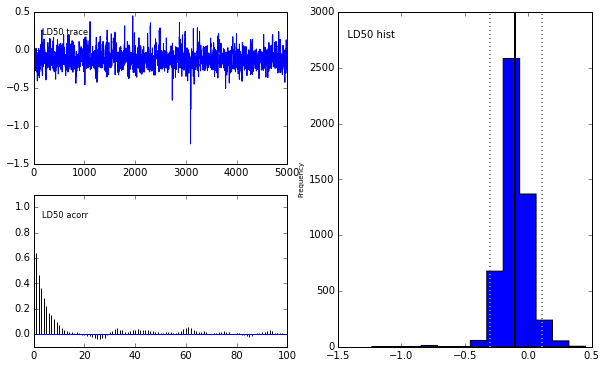

In [31]:
%matplotlib inline
pm.Matplot.plot(M.LD50)

## Reading assignment

[Haario H, Saksman E, Tamminen J.](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.bj/1080222083) (2001) An adaptive Metropolis algorithm. Bernoulli. 7(2):223–242.
